In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing()


maximal elements:
tensor(1.5708, dtype=torch.float64)
tensor(-1.5708, dtype=torch.float64)


In [ ]:
X = torch.tensor(iris['data'], dtype=torch.float64)
y = torch.tensor(iris['target'], dtype=torch.float64)
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

print("maximal elements:")
print(torch.max(X_scaled.flatten()))
print(torch.min(X_scaled.flatten()))

In [5]:
# generate frequencies
max_freq = 5
dim = X_scaled[0].shape[0]

W = utils.freq_generator(max_freq, dim)

In [6]:
# compute best approximation
ba_coeffs = utils.fourier_best_approx(W, X_train, y_train)

In [7]:
print("training_loss: ",utils.loss(W, ba_coeffs, X_train, y_train))
print("test loss: ",utils.loss(W, ba_coeffs, X_test, y_test))

training_loss:  tensor(3.5009e-13, dtype=torch.float64)
test loss:  tensor(3.8488, dtype=torch.float64)


In [8]:
ba_loss = []
ba_test_loss = []
for max_freq in range(1, 10+1):
    W = utils.freq_generator(max_freq, dim)
    ba_coeffs = utils.fourier_best_approx(W, X_train, y_train)
    ba_loss.append(utils.loss(W, ba_coeffs, X_train, y_train).item()**2)
    ba_test_loss.append(utils.loss(W, ba_coeffs, X_test, y_test).item()**2)
    print("max_freq: ", max_freq)
    print("training_loss: ",utils.loss(W, ba_coeffs, X_train, y_train).item()**2)
    print("test loss: ",utils.loss(W, ba_coeffs, X_test, y_test).item()**2)
    print("parameters: ", len(ba_coeffs))

max_freq:  1
training_loss:  3.1465486972942096
test loss:  1.2301222471577289
parameters:  32
max_freq:  2
training_loss:  3.7640078292401256e-20
test loss:  172.02291091261404
parameters:  162
max_freq:  3
training_loss:  1.7256868727125184e-23
test loss:  67.14295575964084
parameters:  512
max_freq:  4
training_loss:  3.2242782429670486e-24
test loss:  40.15129770606563
parameters:  1250
max_freq:  5
training_loss:  1.2256398764141104e-25
test loss:  14.813456487459387
parameters:  2592
max_freq:  6
training_loss:  3.9921939297302137e-26
test loss:  15.318980941061477
parameters:  4802
max_freq:  7
training_loss:  1.8494267684667258e-26
test loss:  28.172961834530767
parameters:  8192
max_freq:  8
training_loss:  1.5641999249137354e-26
test loss:  23.090448358669256
parameters:  13122
max_freq:  9
training_loss:  4.7845493009982325e-26
test loss:  15.909801106433404
parameters:  20000
max_freq:  10
training_loss:  1.3284793200260994e-25
test loss:  10.735086971545858
parameters:  29

In [9]:
# -----------------------------------------

In [10]:
def train(dataloader, model, loss_fn, optimizer, printing=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if printing == True:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                for param_group in optimizer.param_groups:
                    print("lr: ", param_group['lr'])
        return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [11]:
train_data_list = []
for i in range(len(X_train)):
    data_point = (X_train[i], y_train[i])
    train_data_list.append(data_point)

test_data_list = []
for i in range(len(X_test)):
    data_point = (X_test[i], y_test[i])
    test_data_list.append(data_point)

In [12]:
train_dataloader = DataLoader(train_data_list, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=200, shuffle=True)

In [13]:
W = utils.freq_generator(4, dim)
model = fm.Fourier_model(W)
model.to(device)
loss_fn = nn.MSELoss(reduction='sum') # equiv. to torch.linalg.norm(input-target)**2
optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-3)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

In [ ]:
NN_loss = []
NN_test_loss = []
for max_freq in range(1, 10+1):
    W = utils.freq_generator(max_freq, dim).to(device)
    model = fm.Fourier_model(W)
    model.to(device)
    loss_fn = nn.MSELoss(reduction='sum') # equiv. to torch.linalg.norm(input-target)**2
    optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-3)

    epochs = 100000
    for t in tqdm(range(epochs)):
        # print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
        # scheduler.step()
    print("Done!")
    NN_loss.append(train(train_dataloader, model, loss_fn, optimizer, printing=True))
    NN_test_loss.append(test(test_dataloader, model, loss_fn))

100%|██████████| 100000/100000 [01:51<00:00, 894.95it/s]


Done!
loss: 3.770119  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 0.754717 



100%|██████████| 100000/100000 [01:45<00:00, 944.51it/s]


Done!
loss: 2.091607  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 0.865995 



100%|██████████| 100000/100000 [01:50<00:00, 908.11it/s]


Done!
loss: 1.397399  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 3.505841 



100%|██████████| 100000/100000 [01:49<00:00, 916.70it/s]


Done!
loss: 0.727753  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 3.870598 



100%|██████████| 100000/100000 [01:52<00:00, 884.97it/s]


Done!
loss: 4.662573  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 8.864640 



100%|██████████| 100000/100000 [03:05<00:00, 539.67it/s]


Done!
loss: 6.258874  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 11.184166 



100%|██████████| 100000/100000 [05:09<00:00, 322.88it/s]


Done!
loss: 0.028676  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 20.016375 



100%|██████████| 100000/100000 [13:23<00:00, 124.53it/s]


Done!
loss: 0.000705  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 21.334272 



100%|██████████| 100000/100000 [24:34<00:00, 67.84it/s] 


Done!
loss: 5.479155  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 46.7%, Avg loss: 19.587521 



 10%|▉         | 9613/100000 [04:05<39:43, 37.93it/s]  

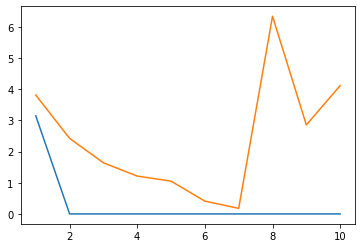

In [15]:
w = np.arange(1, 10+1, 1)
plt.plot(w, ba_loss)
plt.plot(w, NN_loss)

In [17]:
save = True
save_path = "../data/IRIS_03/"
if save == True:
    np.save(save_path+"NN_loss.npy", np.array(NN_loss))
    np.save(save_path+"NN_test_loss.npy", np.array(NN_test_loss))
    np.save(save_path+"ba_loss.npy", np.array(ba_loss))
    np.save(save_path+"ba_test_loss.npy", np.array(ba_test_loss))

(0.0, 100.0)

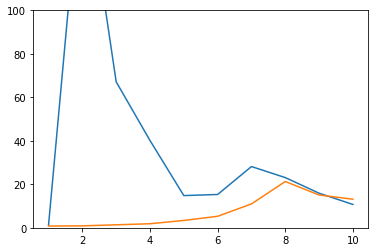

In [18]:
plt.plot(w, ba_test_loss)
plt.plot(w, NN_test_loss)
plt.ylim(0, 100)